# Importing the libraries required for this code
This code is written in Jupyter Notebook (6.4.11).
This is an opensource code, can be modified and distributed for any purpose.
The following is the library packages that we used in the code:
Numpy (1.22.1),
Pandas (1.4.0),
SciPy (1.7.3),
Matplotlib (3.5.1),
Seaborn (0.11.2)

In [8]:
import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy import stats



#from decimal import *
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from matplotlib.collections import PathCollection

# Importing data (dectin-2 U937 cells stimulated with FurFurMan)

The imported input_output consist of input (Doses, first column) and output (GFP, second column) information (See SI section 1).
The total measured input and output is 124488.

In [9]:
input_output = np.genfromtxt("dectin-2 FFM.csv", delimiter = ",")

print("Data: ", input_output)
print("Shape:", input_output.shape)

Data:  [[ 0. 11.]
 [ 0.  2.]
 [ 0.  3.]
 ...
 [ 7. 10.]
 [ 7.  5.]
 [ 7. 17.]]
Shape: (124488, 2)


# Plotting joint distribution of the input (doses) and out (GFP) information

Entropy of input = 3.0
Entropy of output = 1.53
Joint Entropy = 4.23
Mutual Information = 0.3


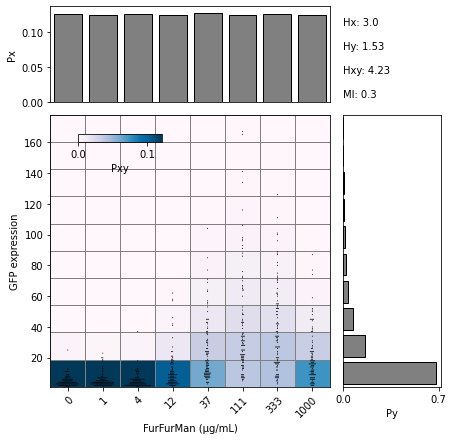

In [10]:


sub_data = np.zeros((0,2))   #due to the large dataset, we subsample the data for the plotting
doses = [0, 1, 4, 12, 37, 111, 333, 1000]
for j, i in enumerate(np.unique(input_output[:,0])):
    temp = input_output[input_output[:,0] == i]
    temp = temp[np.random.choice(np.arange(0, len(temp)), 100) ,:]  #subsampling
    temp[:,0] = doses[j]
    sub_data = np.vstack((sub_data, temp))
sub_data = sub_data.astype(int)


input_binning = len(pd.unique(input_output[:,0]))  #input binning number is the same as the number of input doses
output_binning = 10  #output binning number

Pxy, x_margin, y_margin = np.histogram2d(input_output[:,0], input_output[:,1], bins = [input_binning, output_binning])

x_margin = np.arange(-0.5, len(x_margin)-1)   # for the alignment of the plot


###entropy calculation
Pxy = Pxy/Pxy.sum(axis = None)

Z = Pxy/Pxy.sum(axis = None) + 1E-10
x_marginal = Z.sum(axis = 1) 
y_marginal = Z.sum(axis = 0) 
x_entropy = round((-x_marginal*np.log2(x_marginal)).sum(), 2)
y_entropy = round((-y_marginal*np.log2(y_marginal)).sum(), 2)
joint_entropy = round((-(Z) *np.log2(Z)).sum(axis = None), 2)
mutual_information =  round((x_entropy + y_entropy) - joint_entropy, 2)                                                              
                                                                       

###plotting
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [2, 0.7], 'height_ratios': [0.7, 2]}, figsize = (7,7))
#plt.rcParams['figure.figsize'] = [10, 10]

fig.subplots_adjust(hspace=0.07)
fig.subplots_adjust(wspace=0.07)

axs[0,0].get_xaxis().set_visible(False)
axs[0,0].bar(np.arange(Z.shape[0]), x_marginal, color = "gray", edgecolor  = "k")
axs[0,0].set_xlim((-0.5, Z.shape[0] - 0.5))
axs[0,0].set_ylim([0,max(x_marginal) + 0.01])
axs[0,0].set_xticks([round(0,1), round(x_marginal.max(),1)])
axs[0,0].set_ylabel("Px")

axs[0,1].get_xaxis().set_visible(False)
axs[0,1].get_yaxis().set_visible(False)
axs[0,1].axis('off')
axs[0,1].annotate("Hx: " + str(x_entropy)  , (0,0.8))
axs[0,1].annotate("Hy: " + str(y_entropy) , (0,0.55))
axs[0,1].annotate("Hxy: " + str(joint_entropy)  , (0,0.3))
axs[0,1].annotate("MI: " + str(mutual_information)  , (0,0.05))

c = axs[1,0].pcolormesh(x_margin, y_margin, Pxy.T,cmap ='PuBu', edgecolors='gray', linewidths=0.5)
#cbaxes = inset_axes(axs[1,0], width="30%", height="3%", loc= 2 ) 
cax = axs[1,0].inset_axes([0.1, 0.9, 0.3, 0.03], transform=axs[1,0].transAxes)

cbar = fig.colorbar(c, cax = cax, orientation = "horizontal", ticks = [0.0, round(Pxy.max()-Pxy.max()/7, 2)])
cbar.set_label('Pxy')

#cbar.ax.set_xticklabels([0, round(Pxy.max(), 2)])
axs[1,0].set_xlabel("FurFurMan (\u03BCg/mL)")
sns.swarmplot(x=sub_data[:,0], y=sub_data[:,1], size = 1, color = "k", ax = axs[1,0] )
axs[1,0].set_ylabel("GFP expression")
axs[1,0].set_xlim(-0.5,Z.shape[0]-0.5)

axs[1,0].set_xticklabels(doses, rotation=45, ha="right",  rotation_mode="anchor") 
#axs[1,0].set_xticks([0, 1, 4, 12, 37, 111, 333, 1000])

axs[1,1].get_yaxis().set_visible(False)
axs[1,1].barh(np.arange(Z.shape[1]), y_marginal, color = "gray", edgecolor  = "k")
axs[1,1].set_xlabel("Py")
axs[1,1].set_xticks([round(0,1), round(y_marginal.max(),1)])
axs[1,1].set_ylim((-0.5, Z.shape[1] - 0.5))
print("Entropy of input = " + str(x_entropy))
print("Entropy of output = " + str(y_entropy))
print("Joint Entropy = " + str(joint_entropy))
print("Mutual Information = " + str(mutual_information))

The plot shown above describes the joint probability distribution of the input and output dataset.

# Mutual information optimization function
To optimize (maximize) mutual information using weighting values (see SI section 1 of the Supplemental Information of the paper), we use Sequential Least Squares Programming (SLSQP) (https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html#optimize-minimize-slsqp).

In [11]:
def channel_capacity(data, binnum_mem, binnum_GFP):
    global history
    global entropy_list
    global Pxy_origin
    np.random.seed()
    entropy_list = np.zeros((0,4))    
    p = np.repeat(1/binnum_mem, binnum_mem)
    history = []

    #binning X
    starting_data_input = np.min(data[:,0])    #Low cut-off from blue laser
    ending_data_input =np.max(data[:,0])   #High cut-off from blue laser
    binning_ratio_output =      (ending_data_input - starting_data_input ) /   (binnum_mem)

    next_value_output = starting_data_input
    bin_x =[starting_data_input]  #initial value for y binning
    #generation of y binning interval. it is log scale
    for i in range(0,binnum_mem):
        next_value_output = next_value_output + binning_ratio_output
        bin_x.append(next_value_output) 

    bin_x = np.array(bin_x)
    bin_x[-1] = bin_x[-1] + 0.1

    #binning Y
    starting_data_input = np.min(data[:,1])    #Low cut-off from blue laser
    ending_data_input =np.max(data[:,1])   #High cut-off from blue laser
    binning_ratio_output =      (ending_data_input - starting_data_input ) /   (binnum_GFP)

    next_value_output = starting_data_input
    bin_y =[starting_data_input] 

    for i in range(0,binnum_GFP):
        next_value_output = next_value_output + binning_ratio_output
        bin_y.append(next_value_output) 

    bin_y = np.array(bin_y)

    
    x = data[:,0]
    x = x.astype(int)
    probability_x = []
    temp_x_bin = np.copy(bin_x)
    temp_x_bin = temp_x_bin[1:]
    temp_x_bin[-1] = temp_x_bin[-1] + 1

    bincount_x = np.bincount(np.digitize(x,temp_x_bin))
    
    for i in range(0, len(bincount_x)):
        initial_repeat = list(itertools.repeat(p[i],bincount_x[i]))
        probability_x.extend(initial_repeat)
    
    probability_x = np.array(probability_x)
    data = np.column_stack((data,probability_x.T))
    Pxy_origin, dummy_a, dummy_b = np.histogram2d(data[:,0], data[:,1],  bins = [bin_x, bin_y])     
    
    def MI(p):    
        global entropy_list
        global Pxy_origin
        Pxy=np.copy(Pxy_origin)
        Pxy = Pxy * p[:,np.newaxis]
        Px = Pxy.sum(axis =1)
        Px = Px/sum(Px)
        entropy_Px = -Px*np.nan_to_num(np.log2(Px  + 0.0000001))
        entropy_Px = entropy_Px.sum()
        Py = Pxy.sum(axis =0)
        Py = Py/sum(Py)
        entropy_Py = -Py*np.nan_to_num(np.log2(Py + 0.0000001))
        entropy_Py = entropy_Py.sum()
        Pxy = Pxy/Pxy.sum()
        Jentropy = 0
        Pxy_list = Pxy.flatten()
        Jentropy = -Pxy_list*np.nan_to_num(np.log2(Pxy_list  + 0.0000001))
        Jentropy = Jentropy.sum()
        MI = entropy_Px + entropy_Py - Jentropy
        p = p/p.sum()
        temp_entropy_list = np.array([entropy_Px, entropy_Py, Jentropy, MI])
        entropy_list = np.vstack((entropy_list, temp_entropy_list))             
        values = Px
        history.append(values)
        return -MI

    
    bin_vs_MI = []
    for i in range(2,1):
        value = MI(i)
        bin_vs_MI.append(value)

    history = []
    
    def constraint1(p):
        return sum(p)- 1
        
    b = np.array([[0.0, 10.0]])
    bnds = np.repeat(b, len(p),axis=0)

    con1 = {"type": "eq", "fun": constraint1}
    
    cons = [con1]
    minimize(MI, p,  bounds = bnds, constraints = cons,options={ 'disp': False},  method = "SLSQP")
    history = np.array(history)
    pd.history = pd.DataFrame(history)

    return entropy_list[-1,3] 

# Mutual information maximization

In [12]:
CC = channel_capacity(input_output, input_binning , output_binning) #we already defined input binning and output binning
print("Channel capacity: ", CC)

Channel capacity:  0.43404026041191335


# Estimation of channel capacity at infinite sample size using bootstrapping
Note that the number of sample size of our input and output dataset is 124488.
Using bootstrapping, we can estimate channel capacity at infinite sample size.
Please see the detailed information in SI section 1.7.
For short, we will do subsampling from the original data (i.e. input_output) by 50, 60, 70, 80, 90 and 100% with replacement. Then plot CC with the inverse of the sample size and extrapolate CC at infinite sample size (i.e.,0).

In [13]:
#subsampling procedure
data_list = pd.DataFrame(columns = ["Sample size", "Trial", "Channel capacity"]) #making an empty dataset

subsample_percentage_list = [50, 60, 70, 80, 90, 100]
trial_number = 10   # we will draw the samples 10 times for each subsampling percentage

for subsample in subsample_percentage_list:
    for trial in np.arange(10):
        subsampled_input_output = np.zeros((0,2))
        
        for dose in np.unique(input_output[:,0]):
            temp = input_output[input_output[:,0] == dose]
            index_subsample = np.random.choice(len(temp), int(len(temp)*subsample/100), replace=True)
            temp = temp[index_subsample,:]
            subsampled_input_output = np.vstack((subsampled_input_output, temp))
            
        CC = channel_capacity(subsampled_input_output, input_binning , output_binning) #we already defined input binning and output binning
        data_temp = [len(subsampled_input_output), trial, CC]
        temp_CC_list = pd.DataFrame([data_temp], columns = ["Sample size", "Trial", "Channel capacity"])
        data_list = pd.concat([data_list, temp_CC_list])

data_list.head()      

,Sample size,Trial,Channel capacity
0,62242,0,0.43294
0,62242,1,0.427722
0,62242,2,0.435864
0,62242,3,0.429958
0,62242,4,0.430207


Channel capacity at infinite sample size:  0.4331101876753283


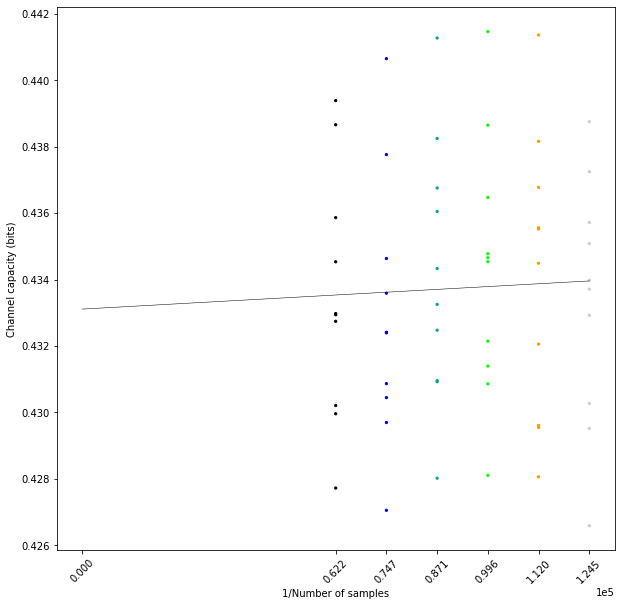

In [15]:
#estimating CC at infinite sample size using linear regression
data_list["Sample size"] = 1/data_list["Sample size"]
data_list = data_list.astype(float)
fig, ax = plt.subplots(1, 1, figsize = (10,10))

max_x = data_list["Sample size"].max()

res = stats.linregress(data_list["Sample size"], data_list["Channel capacity"])
std_cc_at0 = res.intercept_stderr
y0 = res.intercept
slope = res.slope

plt.plot(np.linspace(0,max_x), np.linspace(0,max_x) * slope + y0, color = "k", linewidth = 0.5)


scatter = ax.scatter(data_list["Sample size"], data_list["Channel capacity"], marker=".", 
                     c = data_list["Sample size"],  s = 20, cmap=plt.get_cmap("nipy_spectral"))

ax.set_xlabel("1/Number of samples")
ax.set_ylabel("Channel capacity (bits)")
ax.set_xticks(ticks = np.append(0,np.unique(data_list["Sample size"])))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(rotation = 45)

print("Channel capacity at infinite sample size: ", y0)